# NVCL_KIT Dumbell Plot Demonstration

*Acknowledgment: Borehole dataset courtesy of South Australia Department for Energy and Mining. (https://energymining.sa.gov.au/minerals)*


In [1]:
from nvcl_kit.reader import NVCLReader
from nvcl_kit.param_builder import param_builder

Set up parameters to fetch the first 20 boreholes from South Australia's collection ('sa')

In [2]:
param = param_builder('sa', max_boreholes = 20)
if not param:
    print("Cannot build parameters for South Australia")

Initialise reader object and check for errors

In [3]:
reader = NVCLReader(param)
if not reader.wfs:
        print("ERROR!")

Get borehole information from WFS service

In [4]:
bh_list = reader.get_boreholes_list()

A simple function to get first set of borehole data given an NVCL id

In [5]:
def get_bh_data(nvcl_id):
    logs_data_list = reader.get_logs_data(nvcl_id)
    for ld in logs_data_list:
        # Log name has 2 parts:
        # 1. Min1,2,3 = 1st, 2nd, 3rd most common mineral
        #    OR Grp1,2,3 = 1st, 2nd, 3rd most common group of minerals
        # 2. uTSAV = visible light, uTSAS = shortwave IR, uTSAT = thermal IR
        #
        # These combine to give us a class name such as 'Grp1 uTSAS'
        #
        # Here we extract data for log type '1' and log name 'Grp1 uTSAS'
        if ld.log_type == '1' and ld.log_name == 'Grp1 uTSAS':
            
            # Read top 5 mineral entries, at a 20 depth metre spacing for 'Grp1 uTSAS'
            bh_data = reader.get_borehole_data(ld.log_id, 20, 'Grp1 uTSAS', top_n=5)
            return bh_data
    return None


Get data and names from first and second boreholes

In [6]:
bh_data1 = get_bh_data(bh_list[0]['nvcl_id'])
bh_name1 = bh_list[0]['name']

bh_data2 = get_bh_data(bh_list[1]['nvcl_id'])
bh_name2 = bh_list[1]['name']

Get the list of depths that both boreholes have in common

In [7]:
depths = list(set(bh_data1).intersection(set(bh_data2)))

Assemble the Xs and Ys etc. to make the graph

In [8]:
# y1 - list of y values for borehole1
# y2 - list of y values for borehole2
# x - list of x values common to both boreholes 
# colours - list of colours for each (x,y1) & (x,y2)
# dup_set - a set used to make sure a dumbell isn't drawn twice
# legend_set - a set used to assemble colours & text for the legend
y1, y2, x, colours, dup_set, legend_set = ([],[], [], [], set(), set())

# Loop over depth range
for dep in depths:
    colour_idx = 0
    # Loop over all mineral classes at a depth for borehole 1
    for elem1 in bh_data1[dep]:
        
        # Loop over all mineral classes at a depth for borehole 2
        for elem2 in bh_data2[dep]:
            # If bore1 and bore2 have the same mineral class, and we have not done this combination yet 
            if elem1.classText == elem2.classText and (dep, elem1.classCount, elem2.classCount) not in dup_set:
                y1.append(elem1.classCount)
                x.append(dep+colour_idx)
                y2.append(elem2.classCount)
                colours.append(elem1.colour)
                legend_set.add((elem1.colour, elem1.classText))
                dup_set.add((dep, elem1.classCount, elem2.classCount))
                # Slightly change x value so that dumbells aren't drawn on top of one another 
                colour_idx += 5
                
        

Plot the graph

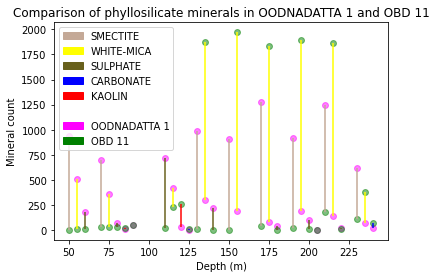

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Setup vertical lines, transparency=1.0
plt.vlines(x=x, ymin=y1, ymax=y2, color=colours, alpha=1.0)

# Borehole 1 is magenta, size=35, transparency=0.5
plt.scatter(x, y1, s=35, c='magenta', alpha=0.5)

# Borehole 2 is green, size=35, transparency=0.5
plt.scatter(x, y2, s=35, c='green', alpha=0.5)

# Assemble the legend
legend_list = [mpatches.Patch(color=colour, label=mineral_name) for colour, mineral_name in list(legend_set)]
legend_list.append(mpatches.Patch(color='white', label=' '))
legend_list.append(mpatches.Patch(color='magenta', label=bh_name1))
legend_list.append(mpatches.Patch(color='green', label=bh_name2))

# Display the graph
plt.legend(handles=legend_list)
plt.ylabel('Mineral count')
plt.xlabel('Depth (m)')
plt.title("Comparison of phyllosilicate minerals in {} and {}".format(bh_name1, bh_name2))
plt.show()